In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from IPython.core.debugger import set_trace

In [ ]:
import torchvision
import torch
from torch import nn
import cv2

In [ ]:
model = torch.load('./resnext-101-kinetics-ucf101_split1.pth')

In [ ]:
model

In [ ]:
from params import *
path = '/data/GaitData/CroppedFrameArrays/7026976_test_0_trial_0.npy'
frames = np.load(path)

In [ ]:
frame = frames[10]
model_conv = torchvision.models.resnet101(pretrained=True)
modules = nn.Sequential(*list(model_conv.children())[:-2])
res = modules(torch.from_numpy(cv2.resize(frame, (128,384)).transpose(2,0,1)[None,:,:,:].astype(np.float32)/255))

plt.imshow(cv2.resize(frame, (128,384))); plt.show()
plt.imshow(cv2.resize(res[0].mean(0).detach().numpy(),(128,384) )); plt.show()

In [ ]:
import cv2
import os
for i in range(len(os.listdir('./feats_viz'))): 
    plt.imshow(np.mean([cv2.cvtColor(cv2.imread(os.path.join('feats_viz',f)),cv2.COLOR_BGR2RGB) for f in os.listdir('./feats_viz')[:i+1]],0)/255); 
    plt.show()

In [ ]:
from collections import defaultdict
traj_data = json.load(open('./UDysRS_UPDRS_Export/LA_split_all_export.txt'))
traj_data_dict = defaultdict(list)

maxlen = 0
for key, val in traj_data.items():
    body_parts = sorted(val['position'].keys())
    body_parts = list(x for x in body_parts if '_' in x)
    
    
    body_dict = defaultdict(list)
    for b in body_parts:
        pure_name = b.split('_')[0]
        body_dict[pure_name] += val['position'][b]
    
    position_vec = np.array(list(body_dict.values())).flatten()
    if len(position_vec) > maxlen:
        maxlen = len(position_vec)
        
    traj_data_dict['position'].append(  position_vec  )

for i in range(len(traj_data_dict['position'])):
    pos = traj_data_dict['position'][i].tolist()
    traj_data_dict['position'][i] = np.array(pos + [ 0.0 ] * (maxlen-len(traj_data_dict['position'][i])))

traj_df = pd.DataFrame(data=traj_data_dict, index=traj_data.keys())
traj_df.index

score_data = json.load(open('./UDysRS_UPDRS_Export/UPDRS.txt'))['Total']
score_data_dict = {}
score_data_dict['score'] = list(score_data.values())

score_df = pd.DataFrame(data=score_data_dict, index=score_data.keys())
len(score_df)

traj_df = traj_df.loc[score_df.index].dropna()
score_df = score_df.loc[traj_df.index].dropna()

X =np.array(traj_df.position.values.tolist())
y = score_df.score.values

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lm = RandomForestRegressor(n_jobs=-1)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred))
def MSE(y_true, y_pred):
    return np.mean( np.square(y_true-y_pred)  )
def RMSLE(y_true, y_pred):
    return np.mean( np.square(np.log(y_true+1)-np.log(y_pred+1)))

print('MAE : ', MAE(y_test, y_pred))
print('MSE : ', MSE(y_test, y_pred))
print('RMSLE : ', RMSLE(y_test, y_pred))

y_pred

y_test

np.abs(y_pred-y_test).mean()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
plt.ion()
%matplotlib inline

In [ ]:
file = '../../preprocess/data/targets_dataframe.pkl'

In [ ]:
df = pd.read_pickle(file).iloc[:,:-2]
df.head()

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,15))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax, annot=True)

In [ ]:
g = sns.PairGrid(df)
g.map(plt.scatter)

In [ ]:
plt.show()

In [ ]:
plt.plot(sorted(np.abs(corr["Velocity"].values)))

In [ ]:
corr.columns

In [ ]:
import matplotlib.ticker as plticker

In [ ]:
fig, axes = plt.subplots(len(corr.columns), figsize=(25,25))

step = 1
for ax,col in zip(axes,corr.columns):
    values = np.abs(corr[col].values)
    ixs = np.argsort(-values)
    
    names = corr.columns[ixs].values
    values = values[ixs]
    ax.plot(np.arange(step*len(ixs), step=step), values, '*-', linewidth=1)
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    xticks = list(ax.get_xticks())
    for i in range(len(names)):
        xticks[i] = names[i]
        
    xticks = [''] + xticks
    ax.set_xticklabels(xticks,fontsize=8, rotation=15)

    ax.set_title(col)
    ax.set_ylabel('|correlation|')

plt.tight_layout()


In [ ]:
df_trans = df.T
df_summary = df_trans.iloc[:3]
df_pair = df_trans.iloc[3:]

columns = [ s.split('/')[0] for s in df_pair.index.values ]

new_colums = []
for col in columns:
    if col not in new_colums:
        new_colums.append(col.strip())

avged_data = {}
odds, evens = np.arange(start=1, stop=len(df_pair),step=2), np.arange(start=0, stop=len(df_pair),step=2)
for ix, (odd, even) in enumerate(zip(odds, evens)):
    avged = np.mean([df_pair.iloc[odd], df_pair.iloc[even]], axis=0).T
    name=df_pair.iloc[2*ix].name.split('/')[0].strip()
    avged_data[name] = avged
    
df_pair_avg = pd.DataFrame(avged_data, index=df_pair.columns).T

In [ ]:
df_summary.head()

In [ ]:
df_pair_avg.head()

In [ ]:
df_trans = pd.concat([df_summary, df_pair_avg])
df_trans

In [ ]:
df_trans.T.corr()

In [ ]:
measurements = df_trans.values
measurements.shape

In [ ]:
C = np.cov(df_trans.values)
C.shape

In [ ]:
target_factors = df_trans.index.values.tolist()
target_factors

In [ ]:
target_factors = df_trans.index.values.tolist()
target_factors.pop(target_factors.index('Toe In'))

In [ ]:
np.random.seed(16); rand_ixs = np.random.permutation(len(target_factors))
target_factors = np.array(target_factors)[rand_ixs].tolist()

In [ ]:
target_factors

In [ ]:
df_trans = df_trans.reindex(target_factors)
df_trans

In [ ]:
corr = df_trans.T.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math

n_clusters = 3

# (n_variables x n_sample)
measurements = df_trans.values

# This generates 100 variables that could possibly be assigned to 5 clusters
n_variables, n_samples = measurements.shape


# To keep this example simple, each cluster will have a fixed size
cluster_size = n_variables // n_clusters

C = df_trans.T.corr().values

def score(C):
    '''
    Function to assign a score to an ordered covariance matrix.
    High correlations within a cluster improve the score.
    High correlations between clusters decease the score.
    '''
    score = 0
    for cluster in range(n_clusters):
        inside_cluster = np.arange(cluster_size) + cluster * cluster_size
        outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

        # Belonging to the same cluster
        score += np.sum(C[inside_cluster, :][:, inside_cluster])

        # Belonging to different clusters
        score -= np.sum(C[inside_cluster, :][:, outside_cluster])
        score -= np.sum(C[outside_cluster, :][:, inside_cluster])

    return score


initial_C = C
initial_score = score(C)
initial_ordering = np.arange(n_variables)

plt.figure()
plt.imshow(C, interpolation='nearest')
plt.title('Initial C')
print('Initial ordering:', [df_trans.index.values[i] for i in initial_ordering])
print('Initial covariance matrix score:', initial_score)

# Pretty dumb greedy optimization algorithm that continuously
# swaps rows to improve the score
def swap_rows(C, var1, var2):
    '''
    Function to swap two rows in a covariance matrix,
    updating the appropriate columns as well.
    '''
    D = C.copy()
    D[var2, :] = C[var1, :]
    D[var1, :] = C[var2, :]

    E = D.copy()
    E[:, var2] = D[:, var1]
    E[:, var1] = D[:, var2]

    return E

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 2000
for i in range(max_iter):
    # Find the best row swap to make
    best_C = current_C
    best_ordering = current_ordering
    best_score = current_score
    for row1 in range(n_variables):
        for row2 in range(n_variables):
            if row1 == row2:
                continue
            option_ordering = best_ordering.copy()
            option_ordering[row1] = best_ordering[row2]
            option_ordering[row2] = best_ordering[row1]
            option_C = swap_rows(best_C, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C = option_C
                best_ordering = option_ordering
                best_score = option_score

    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C
        current_ordering = best_ordering
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break
        
# Output the result
plt.figure()
plt.imshow(current_C, interpolation='nearest')
plt.title('Best C')
print('Best ordering:', [df_trans.index.values[i] for i in current_ordering])
print('Best score:', current_score)
print()
print('Cluster     [variables assigned to this cluster]')
print('------------------------------------------------')

import copy
current_ordering = current_ordering.tolist()
tmp = copy.copy(current_ordering)

cluster = 0
while 1:
    start, end = cluster*cluster_size, (cluster+1)*cluster_size
    print('Cluster %02d  %s' % (cluster + 1, [ df_trans.index.values[i] for i in current_ordering[start:end]]))
    for e in current_ordering[start:end]:
        tmp.pop(tmp.index(e))
        
    cluster += 1
    if not tmp:
        break

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# This generates 100 variables that could possibly be assigned to 5 clusters
n_variables = 100
n_clusters = 5
n_samples = 1000

# To keep this example simple, each cluster will have a fixed size
cluster_size = n_variables // n_clusters

# Assign each variable to a cluster
belongs_to_cluster = np.repeat(range(n_clusters), cluster_size)
np.random.shuffle(belongs_to_cluster)

# This latent data is used to make variables that belong
# to the same cluster correlated.
latent = np.random.randn(n_clusters, n_samples)

variables = []
for i in range(n_variables):
    variables.append(
        np.random.randn(n_samples) + latent[belongs_to_cluster[i], :]
    )

variables = np.array(variables)

C = np.cov(variables)

def score(C):
    '''
    Function to assign a score to an ordered covariance matrix.
    High correlations within a cluster improve the score.
    High correlations between clusters decease the score.
    '''
    score = 0
    for cluster in range(n_clusters):
        inside_cluster = np.arange(cluster_size) + cluster * cluster_size
        outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

        # Belonging to the same cluster
        score += np.sum(C[inside_cluster, :][:, inside_cluster])

        # Belonging to different clusters
        score -= np.sum(C[inside_cluster, :][:, outside_cluster])
        score -= np.sum(C[outside_cluster, :][:, inside_cluster])

    return score


initial_C = C
initial_score = score(C)
initial_ordering = np.arange(n_variables)

plt.figure()
plt.imshow(C, interpolation='nearest')
plt.title('Initial C')
print('Initial ordering:', initial_ordering)
print('Initial covariance matrix score:', initial_score)

# Pretty dumb greedy optimization algorithm that continuously
# swaps rows to improve the score
def swap_rows(C, var1, var2):
    '''
    Function to swap two rows in a covariance matrix,
    updating the appropriate columns as well.
    '''
    D = C.copy()
    D[var2, :] = C[var1, :]
    D[var1, :] = C[var2, :]

    E = D.copy()
    E[:, var2] = D[:, var1]
    E[:, var1] = D[:, var2]

    return E

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 1000
for i in range(max_iter):
    # Find the best row swap to make
    best_C = current_C
    best_ordering = current_ordering
    best_score = current_score
    for row1 in range(n_variables):
        for row2 in range(n_variables):
            if row1 == row2:
                continue
            option_ordering = best_ordering.copy()
            option_ordering[row1] = best_ordering[row2]
            option_ordering[row2] = best_ordering[row1]
            option_C = swap_rows(best_C, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C = option_C
                best_ordering = option_ordering
                best_score = option_score

    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C
        current_ordering = best_ordering
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break

# Output the result
plt.figure()
plt.imshow(current_C, interpolation='nearest')
plt.title('Best C')
print('Best ordering:', current_ordering)
print('Best score:', current_score)
print()
print('Cluster     [variables assigned to this cluster]')
print('------------------------------------------------')
for cluster in range(n_clusters):
    print('Cluster %02d  %s' % (cluster + 1, current_ordering[cluster*cluster_size:(cluster+1)*cluster_size]))

In [ ]:
a = A()
a.fuck()

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
path = '/data/GaitData/CroppedFrameArrays/7026976_test_0_trial_3.npy'

In [ ]:
arr = np.load(path)

In [ ]:
arr.shape

In [ ]:
for e in arr:
    plt.imshow(cv2.cvtColor(e,cv2.COLOR_BGR2RGB))
    plt.show()
    

In [ ]:
import pandas as pd
file = '../../preprocess/data/targets_dataframe.pkl'

In [ ]:
df = pd.read_pickle(file)

In [ ]:
df.columns

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer

In [ ]:
scaler = QuantileTransformer(random_state=0, output_distribution='normal')
scaled_X1 = scaler.fit_transform((df['Toe In / Out/R']).values[:, None])
plt.hist(scaled_X1, bins=100)

In [ ]:
scaler = QuantileTransformer(random_state=0, output_distribution='normal')
scaled_X2 = scaler.fit_transform((df['Toe In / Out/R']+90).values[:, None])
plt.hist(scaled_X2, bins=100)

In [ ]:
import numpy as np
np.where(scaled_X1 != scaled_X2)

In [ ]:
scaled_X1[8]

In [ ]:
scaled_X2[8]

In [ ]:
df['Toe In / Out/R'] = df['Toe In / Out/R']+90

In [ ]:
plt.hist(df['CV Stride Length/R'], bins=100)

In [ ]:
df.columns

In [ ]:
plt.hist(df['Swing % of Cycle/L'], bins=100)

In [ ]:
df['Stance % of Cycle/L'][1]

In [ ]:
df['Stance Time(sec)/L'][1]/df['Cycle Time(sec)/L'][1]

In [ ]:
df['Stance % of Cycle/L'][0]

In [ ]:
df['Stance Time(sec)/L'][0]/df['Cycle Time(sec)/L'][0]

In [ ]:
df['Double Supp % Cycle/L'][1]

In [ ]:
df['Double Supp. Time(sec)/L'][0]/df['Cycle Time(sec)/L'][0]

In [ ]:
df['Stride Length Std Dev/L'][0]/df['Stride Length(cm)/L'][0]

In [ ]:
plt.hist(df['Stride Length(cm)/L'], bins=100)

In [ ]:
plt.hist(df['Stride Length Std Dev/L'], bins=100)

In [ ]:
for i in range(10):
    print(df['Stride Length(cm)/L'][i], df['Stride Length Std Dev/L'][i])

In [ ]:
plt.scatter(df['Stride Length(cm)/L'].values, df['Stride Length Std Dev/L'])

In [ ]:
df['Stride Length(cm)/L'][0]

In [ ]:
df_X2 = df['Stride Length Std Dev/L']**2 + df['Stride Length(cm)/L']**2
scaler = QuantileTransformer(random_state=0, output_distribution='normal')
plt.hist(scaler.fit_transform(df_X2[:,None]), bins=100)

In [ ]:
df_X2

In [115]:
import pandas as pd
file = '../../preprocess/data/targets_dataframe.pkl'
df = pd.read_pickle(file)
df = df[~(df == 0).any(axis=1)]
import numpy as np
np.abs(df.values).min()

0.00028900000000000003

In [128]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [134]:
scaler = StandardScaler()

# scaler = Pipeline([
#     ('qt', scaler),
#     ('minmax', MinMaxScaler())
# ])

scaled_vals = scaler.fit_transform(df)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,
          1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   5.,   0.,   2.,   1.,   6.,   4.,  17.,  15.,
         29.,  24.,  25.,  44.,  22.,  65.,  63.,  77., 101.,  94., 102.,
        117., 141., 127., 131., 169., 172., 165., 141., 148., 154., 157.,
        123., 132., 141., 120., 121., 104.,  83.,  80.,  96.,  75.,  51.,
         62.,  31.,  20.,  23.,  22.,  13.,  17.,  11.,   8.,  10.,   5.,
          9.,   4.,   4.,   6.,   3.,   1.,   4.,   3.,   4.,   1.,   2.,
          0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,
          1.]),
 array([-30.3  , -29.489, -28.678, -27.867, -27.056, -26.245, -25.434,
        -24.623, -23.812, -23.001, -22.19 , -21.379, -20.568, -19.757,
        -18.946, -18.135, -17.324, -16.513, -15.702, -14.891, -14.08 ,
        -13.269, -12.458, -11.647, -10.836, -10.025,  -9.214,  -8.403,
         -7.592,  -6.781,  -5.97 ,

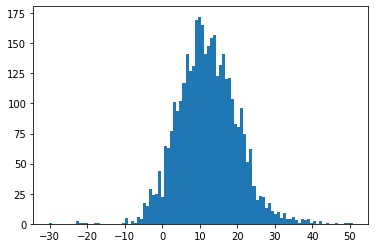

In [135]:
plt.hist(df.values[:, 16], bins=100)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,
          1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   5.,   0.,   2.,   1.,   6.,   4.,  17.,  15.,
         29.,  24.,  25.,  44.,  22.,  65.,  63.,  77., 101.,  94., 102.,
        117., 141., 127., 131., 169., 172., 165., 141., 148., 154., 157.,
        123., 132., 141., 120., 121., 104.,  83.,  80.,  96.,  75.,  51.,
         62.,  31.,  20.,  23.,  22.,  13.,  17.,  11.,   8.,  10.,   5.,
          9.,   4.,   4.,   6.,   3.,   1.,   4.,   3.,   4.,   1.,   2.,
          0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,
          1.]),
 array([-5.36264722, -5.26017612, -5.15770502, -5.05523392, -4.95276282,
        -4.85029172, -4.74782062, -4.64534952, -4.54287842, -4.44040732,
        -4.33793622, -4.23546512, -4.13299402, -4.03052292, -3.92805182,
        -3.82558072, -3.72310962, -3.62063852, -3.51816742, -3.41569632,
        -3.31322522, -3.21

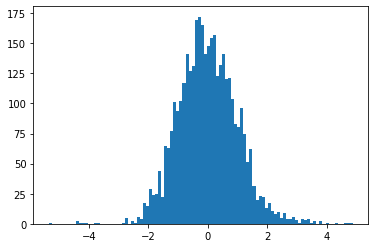

In [136]:
plt.hist(scaled_vals[:, 16], bins=100)

In [107]:
list(df.columns).index('Toe In / Out/L')

16

In [139]:
df['Toe In / Out/L'].describe()

count    3723.000000
mean       12.142278
std         7.915490
min       -30.300000
25%         7.000000
50%        11.800000
75%        17.200000
max        50.800000
Name: Toe In / Out/L, dtype: float64

In [141]:
df['Velocity'].describe()

count    3723.000000
mean       71.108515
std        27.139210
min         7.000000
25%        51.800000
50%        71.500000
75%        90.200000
max       192.300000
Name: Velocity, dtype: float64

In [142]:
df['Stride Time Std Dev/L'].describe()

count    3723.000000
mean        0.067861
std         0.119826
min         0.001000
25%         0.026000
50%         0.042000
75%         0.068000
max         2.350000
Name: Stride Time Std Dev/L, dtype: float64

In [144]:
df['Cycle Time(sec)/L'].describe()

count    3723.000000
mean        1.161489
std         0.253123
min         0.716000
25%         1.033000
50%         1.119000
75%         1.223000
max         5.669000
Name: Cycle Time(sec)/L, dtype: float64

In [145]:
from sklearn.datasets import fetch_olivetti_faces

In [146]:
data = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [154]:
data.images.max()

1.0

In [155]:
import pandas as pd

In [156]:
df = pd.read_pickle('../../preprocess/data/targets_dataframe.pkl')

In [168]:
df['Stride Length Std Dev/L'][0], df['Stride Length(cm)/R'][0]

(1.918, 128.717)

(array([7.160e+02, 1.786e+03, 8.810e+02, 2.650e+02, 7.900e+01, 2.400e+01,
        7.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0.    ,  2.9705,  5.941 ,  8.9115, 11.882 , 14.8525, 17.823 ,
        20.7935, 23.764 , 26.7345, 29.705 ]),
 <a list of 10 Patch objects>)

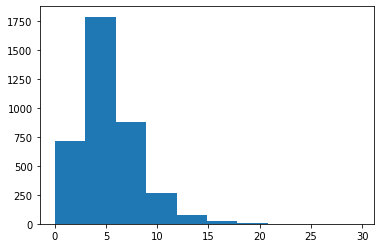

In [172]:
plt.hist(df['Stride Length Std Dev/L'])

(array([7.660e+02, 1.368e+03, 7.720e+02, 3.210e+02, 1.530e+02, 9.400e+01,
        6.600e+01, 4.000e+01, 3.200e+01, 2.000e+01, 1.600e+01, 1.500e+01,
        1.200e+01, 1.100e+01, 4.000e+00, 2.000e+00, 1.000e+00, 8.000e+00,
        1.000e+00, 7.000e+00, 6.000e+00, 5.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

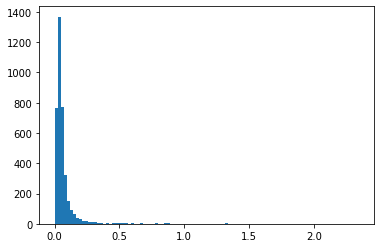

In [170]:
plt.hist(df['Stride Time Std Dev/L'], bins=100)